## DC-MOTOR: Modeling, Simulation and Control

In this notebook the process of modeling a system starting from the real model, to the physical model and contructing the mathematical model.
The simulated response of the model to an input voltage will be computed integrating using Runge-Kutta techniques, using MATLAB's ode45().

The model will then be analysed and tuned for performance, using classic control techniques such as PID control and LQR. The controller will then be tested under parameteric uncertainty and the parameters tuned using $\mu$ - synthesis.

In [1]:
% Defining DC_Motor Parameters
s = tf('s');
J = ureal('J', 0.01,  'Percentage',10);
b = 0.1;
K = 0.01;
R = ureal('R', 1,  'Percentage',10);
L = 0.5;

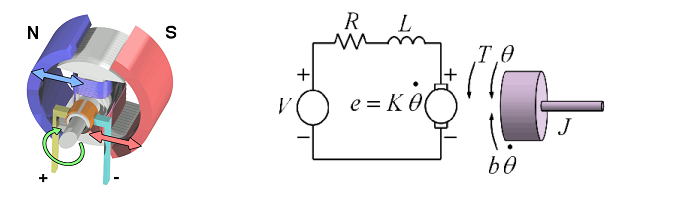

Above is displayed the real model of the DC-motor (Left), and physical model of the DC-motor(Right). The motor is composed of two coupled dynamics, electrical and rotational. Starting from this model, a mathematical derivation can computed with proper assumptions:

• Linearity (ex. linear damping)

• Neglecting small effects (Coulomb friction)

• Lumping (ex. Inertia force)

$$V_R = Ri;\quad V_K = K;\quad V_L = \frac{di}{dt} L \omega$$
$$V_S - V_R - V_L - V_K = 0$$
$$M_f = b\omega;\quad M_K = Ki$$
$$J\dot{\omega} = -M_F + M_K + M_l$$        
        
         
Finally we obtain the following set of equations:

$$L\frac{di}{dt} + Ri + K\omega = V_S$$
$$J\dot{\omega} + b\omega - Ki = M_l$$

From these dynamics, we compute the transfer function from the input voltage Vs to the output rotational speed $\omega$

$$ TF = \frac{K}{(Js+b)(Ls+R)+K^2)}$$

The state space representation is given by:
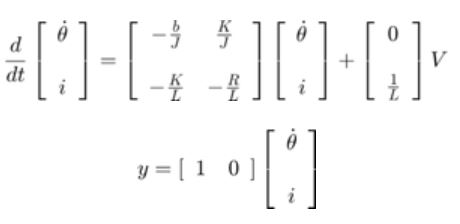

In [2]:
% State space and transfer function representation
A = [-b/J   K/J
    -K/L   -R/L];
B = [0
    1/L];
C = [1   1];
D = 0;
DC_Motor = ss(A,B,C,D);
nom_DC_Motor=DC_Motor.NominalValue


nom_DC_Motor =
 
  A = 
          x1     x2
   x1    -10      1
   x2  -0.02     -2
 
  B = 
       u1
   x1   0
   x2   2
 
  C = 
       x1  x2
   y1   1   1
 
  D = 
       u1
   y1   0
 
Continuous-time state-space model.


# Simulation using ode45()

The system ode is simulated for an input volatage of 10V, the system settles at around 10 rotations per second with a settling time of 2.4 seconds.

A system analysis shows that our model is nomaminally stable, with an infinite gain margin and a phase margin of 150 degrees. The system settling time and steady state error can be analysed using the system step response, and will be tuned to performance in the next section.

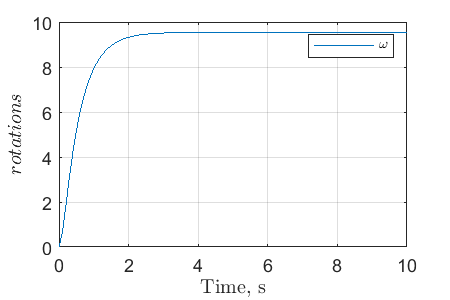

In [3]:
% Simulation for Input voltage of 10
t=linspace(0,10,100);
[t1,Vc1] = ode45(@(t,x) dcmotorfun(t,x),t,[0 0]);
figure(2); plot(t1,Vc1(:,1)*60/2/pi); xlabel('Time, s', 'Interpreter','latex'); ylabel('$rotations$','Interpreter','latex'); grid on;
legend('$\omega$', 'interpreter', 'latex','fontsize',7)
set(gcf,'Position',[100 100 300 200])

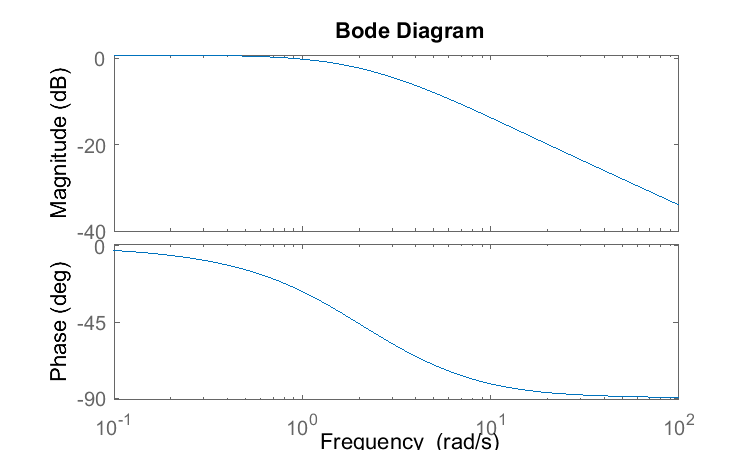

In [4]:
bode(nom_DC_Motor); set(gcf,'Position',[100 100 500 300])

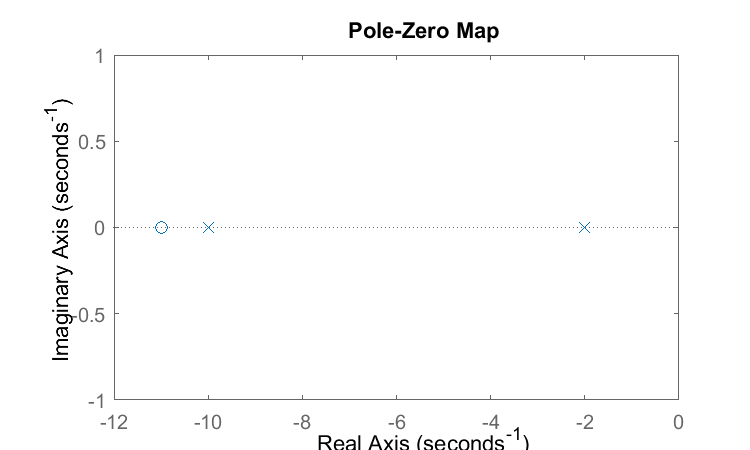

In [5]:
pzplot(nom_DC_Motor); set(gcf,'Position',[100 100 500 300])

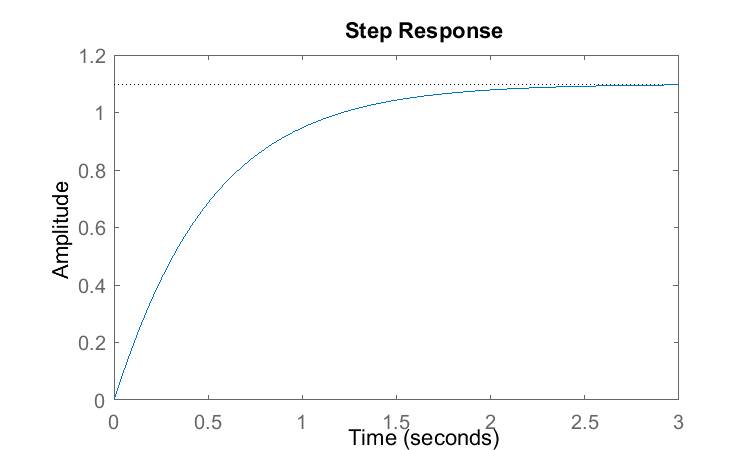

In [6]:
step(nom_DC_Motor); set(gcf,'Position',[100 100 500 300])

# DC-Control using PID

The motor will be controlled to acheive the following requirements for a step response of 1rad/s:

• Settling time less than 2 seconds

• Overshoot less than 5%

• Steady-state error less than 1%

These requirements can be translated into an equivalent response for a second order system with the following natural frequency and damping ratios.

The step response comparison shows that the PID controlled model is much faster than the requirements and nominal plant, with no overshoot and no setlling time. This PID can be tuned less aggerssively to fit other requirements such as product life cycle.

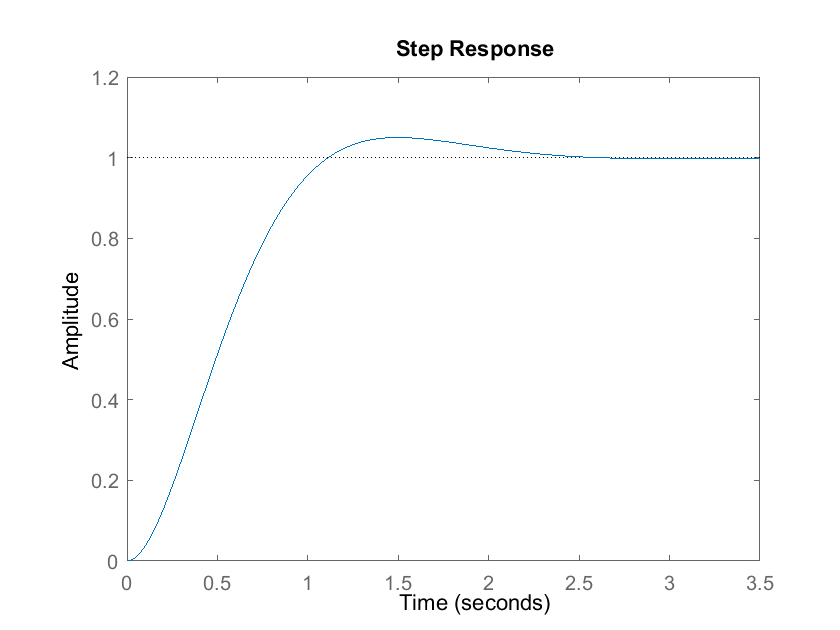

In [7]:
% Calculate natural frequency (wn) and damping ratio (zeta)

desired_overshoot = 5;  % Overshoot limit in percentage
desired_ss_error = 2;   % Steady state error limit in percentage
desired_settling_time = 2;  % Settling time limit in seconds

zeta = -log(desired_overshoot/100)/sqrt(pi^2 + (log(desired_overshoot/100))^2);
wn = 4/(zeta*desired_settling_time);
F = wn^2/(s^2 + 2*s*zeta*wn + wn^2);

step(F)

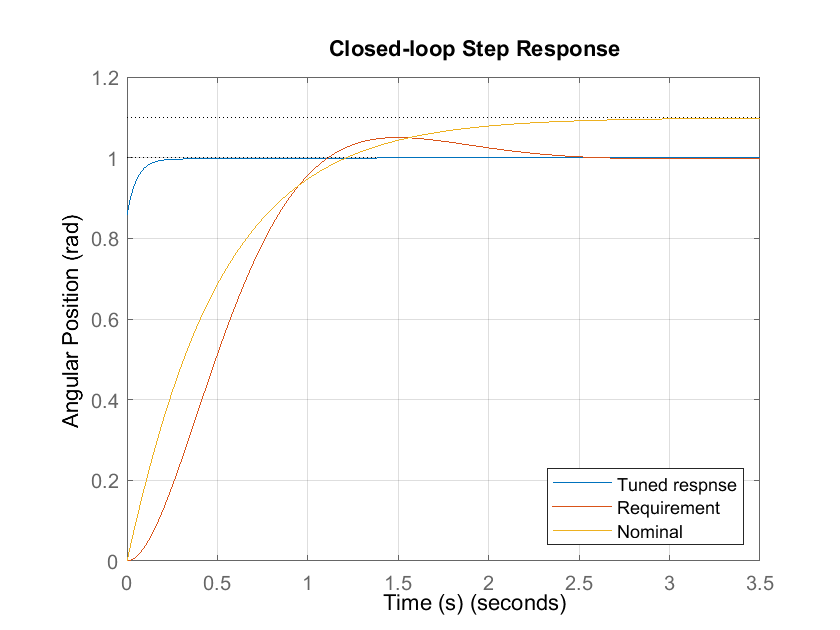

In [8]:
% Calculate PID parameters using the desired performance criteria

Kp = (2*zeta*wn)/0.06;
Ki = wn^2/0.1001;
Kd = 3;

% Create PID Controller
pid_controller = pid(Kp, Ki, Kd);

% Connect the plant and controller
sys_cl = feedback(nom_DC_Motor*pid_controller, 1);
ystepinfo = stepinfo(sys_cl);

figure;
step(sys_cl); hold on; step(F); hold on; step(nom_DC_Motor)
title('Closed-loop Step Response');
xlabel('Time (s)');
ylabel('Angular Position (rad)');
grid on;
legend("Tuned respnse", "Requirement", "Nominal", 'Location','southeast')
grid on;

# Design using LQR

The design requirements can also be fit using a Linear Quadratic Regulator. As seen from the step response, the controlled model is slightly faster than the requirements, with no zero and steady state error.

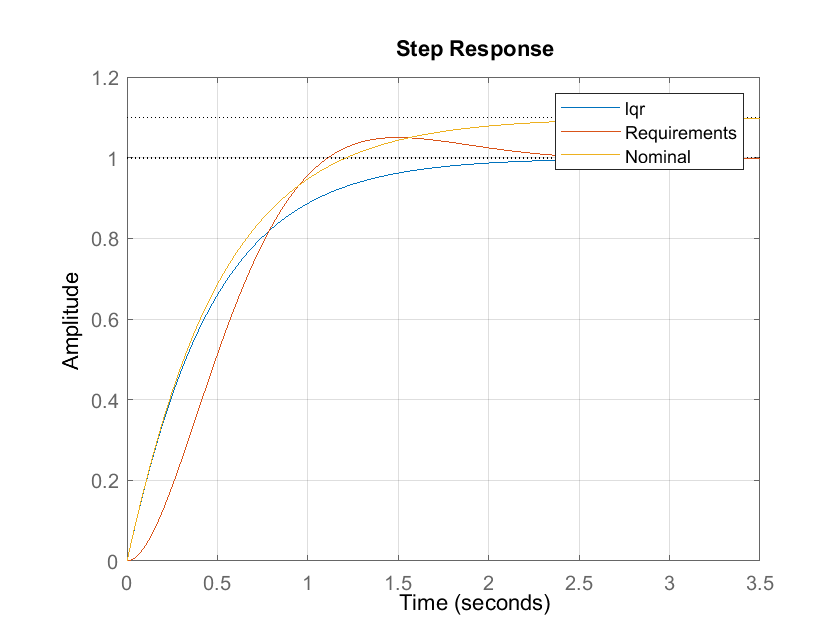

In [9]:
%% Linear Quadratic control
R1 = 230;
Q1 = 230*C'*C;
Q1(2,2)=0.1;
[K1,S1,P1] = lqr(A.NominalValue,B,Q1,R1);

sys1 = ss(A.NominalValue-B*K1,B,C,D);
step(sys1); 
hold on; step(F); hold on; step(nom_DC_Motor);
grid on;
legend("lqr", "Requirements", "Nominal", 'Location','northeast')

# Robust performance to parametric uncertainty using $\mu$ -synthesis



D-K ITERATION SUMMARY:
-----------------------------------------------------------------
                       Robust performance               Fit order
-----------------------------------------------------------------
  Iter         K Step       Peak MU       D Fit             D
    1           1.016        1.003         1.01             0
    2            1.01        1.003         1.01             0
    3            1.01        1.003         1.01             0

Best achieved robust performance: 1



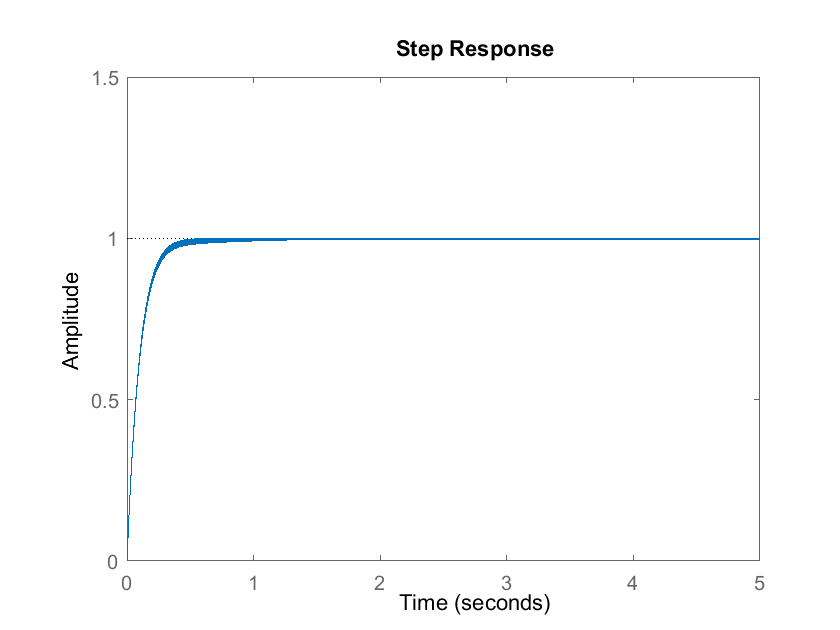

In [10]:
%% Robust control through mu-synthesis
C_tunable = tunablePID('C_tunable', 'PID');
C_tunable.Kp.Value=67;
C_tunable.Ki.Value=83;
C_tunable.Kd.Value=3;
sys_cl_unc = feedback(C_tunable*DC_Motor,1);
[CL,CLperf] = musyn(sys_cl_unc);
step(CL);axis([0 5 0 1.5])